In [2]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [3]:
df= pd.read_excel('Preprocessed_data_2.xlsx')

In [3]:
# Loop through each column and list its unique values
for col in df.columns:
    print(f"Column: {col}")
    unique_values = df[col].unique()
    print(f"Unique Values ({len(unique_values)}): {unique_values}\n")

Column: Family_Structure
Unique Values (2): ['Nuclear family' 'Joint family']

Column: Age
Unique Values (48): [21 22 19 25 23 38 37 40 24 35 36 18 20 44 54 26 65 45 39 47 55 16 46 28
 33 17 68 43 34 62 50 56 32 31 30 53 59 51 42 15 48 60 52 27 49 57 58 29]

Column: Gender
Unique Values (2): ['Male' 'Female']

Column: Occupation
Unique Values (6): ['Student' 'Self-employed' 'Private sector employee' 'Homemaker'
 'Government employee' 'Retired']

Column: Education
Unique Values (4): ['Postgraduate' 'Graduate' 'No formal education' 'Secondary']

Column: Income_Range
Unique Values (7): ['₹75,000 - ₹99,999' '₹25,000 - ₹49,999' '₹1,25,000 - ₹1,49,999'
 '₹1,00,000 - ₹1,24,999' 'More than ₹1,50,000' 'Less than ₹25,000'
 '₹50,000 - ₹74,999']

Column: Primary_Shopper
Unique Values (4): ['Joint responsibility' 'Other family member' 'Self' 'Spouse/partner']

Column: Shopping_Companion
Unique Values (3): ['With family' 'Alone' 'With friends']

Column: Shopping_Frequency
Unique Values (5): ['Once a

In [5]:
df.shape

(235, 61)

1️⃣ **Classification Performance Analysis**  

In [5]:
# To classify individuals into Nuclear or Joint families based on demographic attributes, 
# shopping behaviors, and preferences, uncovering key factors that influence family-based 
# decision-making in grocery shopping.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, _tree
from sklearn.compose import ColumnTransformer
from imblearn.combine import SMOTETomek
from sklearn.metrics import classification_report, confusion_matrix

# Set random seed
random_seed = 42
np.random.seed(random_seed)

# ---------------------------------------
# 1. Load Data
# ---------------------------------------
df= pd.read_excel('Preprocessed_data_2.xlsx')
target_column = 'Family_Structure'
y = df[target_column]

# ---------------------------------------
# 2. Feature Engineering
# ---------------------------------------
numeric_cols = ['Age', 'Spend_Per_Visit', 'Monthly_Spend']
categorical_cols = ['Gender', 'Occupation', 'Education', 'Income_Range',
                    'Shopping_Companion', 'Shopping_Frequency', 'Shopping_Time',
                    'Preferred_Store', 'Product_Preferences', 'Primary_Shopper']
factor_cols = ['Factor_Proximity', 'Factor_Pricing', 'Factor_Variety',
               'Factor_Fresh_Produce', 'Factor_Store_Layout']

# ---------------------------------------
# 3. Preprocessing Pipeline
# ---------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('factors', 'passthrough', factor_cols)
    ]
)

X_processed = preprocessor.fit_transform(df)
if hasattr(X_processed, 'toarray'):
    X_processed = X_processed.toarray()

# ---------------------------------------
# 4. Handle Class Imbalance
# ---------------------------------------
smotetomek = SMOTETomek(random_state=random_seed)
X_resampled, y_resampled = smotetomek.fit_resample(X_processed, y)

# ---------------------------------------
# 5. Train-Test Split
# ---------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=random_seed, stratify=y
)

# ---------------------------------------
# 6. Train Decision Tree Classifier
# ---------------------------------------
decision_tree = DecisionTreeClassifier(
    max_depth=14,
    min_samples_split=3,
    min_samples_leaf=1,
    criterion='gini',
    splitter='best',
    ccp_alpha=0.003520629155636619,
    random_state=random_seed
)
decision_tree.fit(X_resampled, y_resampled)

# ---------------------------------------
# 7. Evaluation
# ---------------------------------------
y_pred = decision_tree.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ---------------------------------------
# 8. Feature Importance
# ---------------------------------------
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = np.concatenate([numeric_cols, cat_features, factor_cols])

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': decision_tree.feature_importances_
}).sort_values('Importance', ascending=False)


print("Top Features:\n", feature_importance.head(10))

Classification Report:
                 precision    recall  f1-score   support

  Joint family       0.85      0.85      0.85        20
Nuclear family       0.89      0.89      0.89        27

      accuracy                           0.87        47
     macro avg       0.87      0.87      0.87        47
  weighted avg       0.87      0.87      0.87        47

Confusion Matrix:
 [[17  3]
 [ 3 24]]
Top Features:
                                  Feature  Importance
2                          Monthly_Spend    0.201334
1                        Spend_Per_Visit    0.161932
0                                    Age    0.057434
32                 Shopping_Time_Morning    0.052676
14                   Education_Secondary    0.046241
23        Shopping_Companion_With family    0.044564
20        Income_Range_₹50,000 - ₹74,999    0.043716
43  Primary_Shopper_Joint responsibility    0.042424
29        Shopping_Frequency_Once a week    0.036999
47                      Factor_Proximity    0.031909


<Figure size 800x600 with 0 Axes>

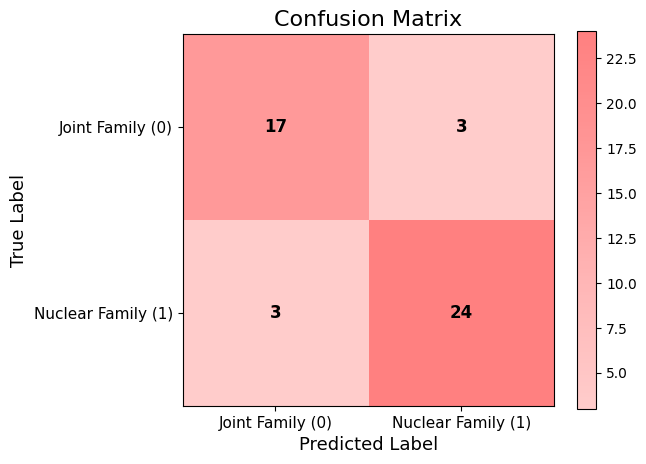

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Create a custom peach colormap
colors = ["#FFCCCB", "#FFB6B6", "#FF9999", "#FF8080"]  # Custom peach shades
peach_cmap = LinearSegmentedColormap.from_list("PeachCmap", colors, N=100)

# Display confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=['Joint Family (0)', 'Nuclear Family (1)'],
    cmap=peach_cmap,
    colorbar=True
)

# Add black text for matrix values
for i, (x, y) in enumerate(np.ndindex(disp.confusion_matrix.shape)):
    value = disp.confusion_matrix[x, y]
    plt.text(
        y, x, value, 
        color="black", 
        ha="center", 
        va="center", 
        fontsize=12, 
        fontweight="bold"
    )

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=13)
plt.ylabel('True Label', fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(False)  # Disable grid for clarity
plt.tight_layout()
plt.show()

### **Classification Performance of the Model**

#### **Overview**
This classification report and confusion matrix assess the model's ability to classify individuals into **Joint family** or **Nuclear family** based on demographic attributes and shopping behaviors.

#### **Key Insights**
✅ **Model Accuracy: 87%** → The classifier performs well, correctly classifying individuals **87% of the time**.  
✅ **Class-Level Performance:**  
   - **Joint family:** Precision **85%**, Recall **85%**, meaning the model correctly identifies **85% of Joint family cases**.  
   - **Nuclear family:** Precision **89%**, Recall **89%**, showing slightly better prediction strength for Nuclear families.  
✅ **Balanced Performance:** The **macro average of precision, recall, and F1-score is 87%**, indicating the model **does not favor one class over another**.

#### **Confusion Matrix Analysis**
📌 **True Positives (Correct Classifications)**  
- **17 cases correctly classified as Joint family**  
- **24 cases correctly classified as Nuclear family**  

📌 **False Predictions (Misclassifications)**  
- **3 Joint family individuals were misclassified as Nuclear family**  
- **3 Nuclear family individuals were misclassified as Joint family**  

#### **Implications for Grocery Shopping Decision Analysis**
- The model effectively identifies **shopping behavior differences** that distinguish **Joint family vs Nuclear family preferences**.  
- Since **misclassifications are minimal**, the features influencing predictions (such as spending habits or preferred grocery items) are likely **strong indicators** of family structure.  
- **Future refinements** could involve analyzing **feature importance**, ensuring that demographic attributes and shopping behaviors contributing to classification are maximized.

2️⃣ **Monthly Spend, Spend Per Visit & Age Comparison**  

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# 1. Average Monthly_Spend and Spend_Per_Visit per class
avg_values = df.groupby('Family_Structure')[['Monthly_Spend', 'Spend_Per_Visit', 'Age']].mean()
avg_values['Age'] = avg_values['Age'].round(0)  # Round off Age to no decimal places

# Display results in a tabular format with proper lines
print("Average Monthly Spend, Spend Per Visit, and Age:")
print(tabulate(avg_values, headers='keys', tablefmt='grid'))  # Shows a properly formatted table with lines

Average Monthly Spend, Spend Per Visit, and Age:
+--------------------+-----------------+-------------------+-------+
| Family_Structure   |   Monthly_Spend |   Spend_Per_Visit |   Age |
+====================+=================+===================+=======+
| Joint family       |         8743.43 |           2770.51 |    34 |
+--------------------+-----------------+-------------------+-------+
| Nuclear family     |         8377.94 |           2570.29 |    30 |
+--------------------+-----------------+-------------------+-------+


### **Comparative Analysis of Monthly Spend, Spend Per Visit, and Age Across Family Structures**

#### **Overview**
This table provides a **comparative breakdown** of **average monthly spending, per-visit spending, and age** for individuals in **Joint family vs Nuclear family structures**. It highlights spending patterns and demographic trends influencing grocery shopping decisions.

#### **Key Insights**
✅ **Monthly Spend**:  
   - **Joint family: ₹8,743.43**  
   - **Nuclear family: ₹8,377.94**  
   - **Difference: ₹365.49 higher in Joint families**  
   📌 **Implication**: Joint families tend to spend **more on groceries overall**, likely due to **higher household consumption** from multiple members.

✅ **Spend Per Visit**:  
   - **Joint family: ₹2,770.51**  
   - **Nuclear family: ₹2,570.29**  
   - **Difference: ₹200.22 higher in Joint families**  
   📌 **Implication**: The **higher per-visit spending in Joint families** suggests they may **buy in bulk** rather than making frequent smaller purchases.

✅ **Age**:  
   - **Joint family: 34 years**  
   - **Nuclear family: 30 years**  
   - **Difference: Joint families skew slightly older**  
   📌 **Implication**: The **older average age in Joint families** may be linked to **traditional household structures**, where shopping responsibilities could be influenced by senior family members.

#### **Implications for Grocery Shopping Decision Analysis**
- **Higher overall grocery spend in Joint families** indicates **greater household consumption**, requiring retailers to **offer larger pack sizes, family-oriented promotions, and bulk discounts**.  
- **Spend Per Visit differences suggest Joint families prefer less frequent but larger purchases**, implying potential marketing strategies focused on **stock-up deals rather than frequent purchase incentives**.  
- **Age differences suggest generational influences in shopping behavior**, with Joint families potentially **prioritizing essential goods**, while Nuclear families may be **more flexible in grocery choices**.

3️⃣ **Top Feature Importance Analysis**  

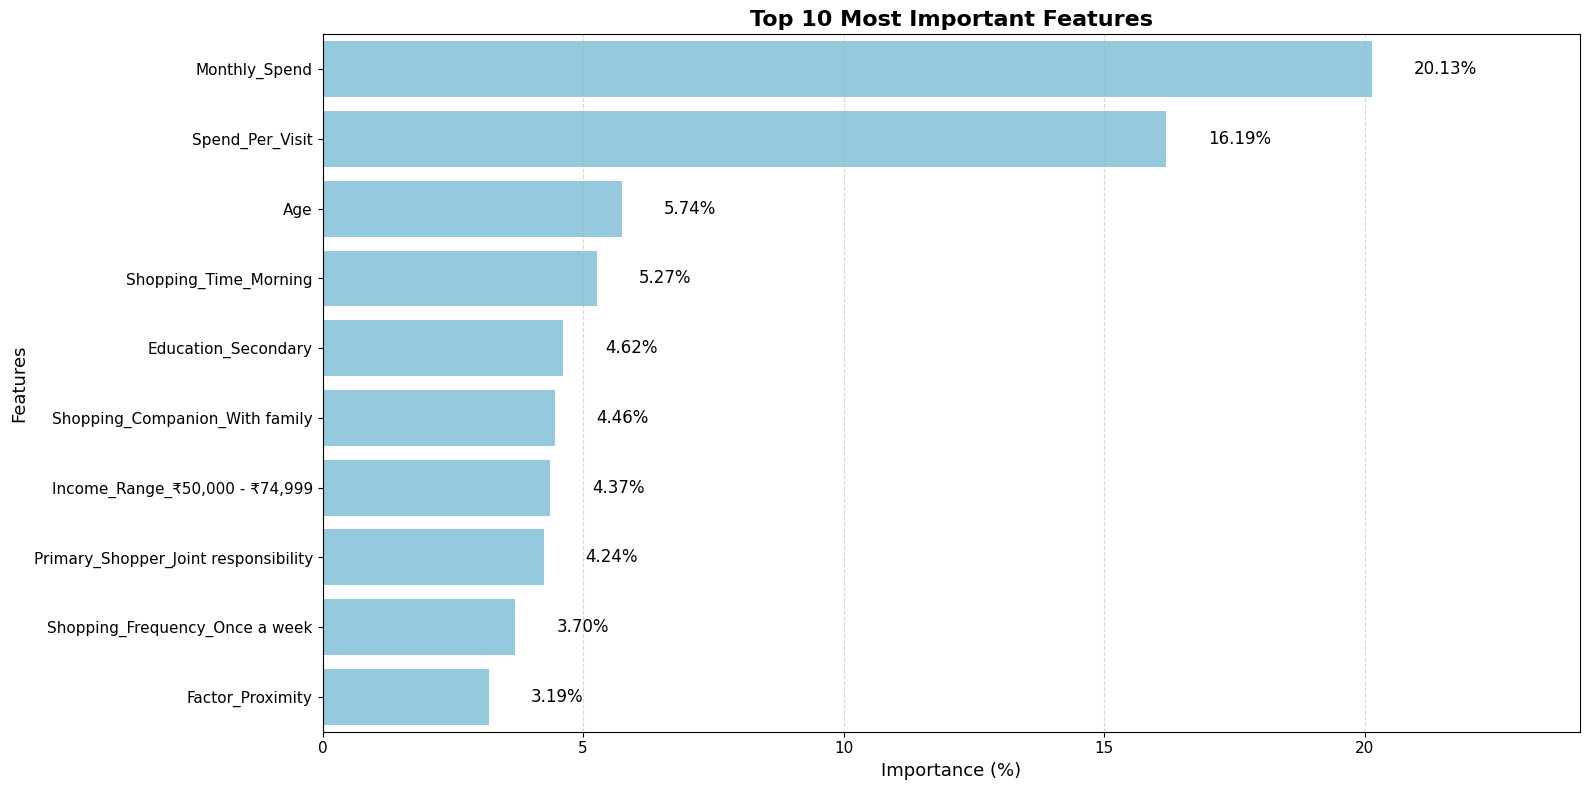

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Importance Visualization
top_features = feature_importance.head(10)
top_features['Importance (%)'] = top_features['Importance'] * 100

# Increase figure size
plt.figure(figsize=(16, 8))

# Create Seaborn barplot
ax = sns.barplot(
    data=top_features,
    x='Importance (%)',
    y='Feature',
    color='skyblue'
)

# Expand x-axis limits slightly
ax.set_xlim(0, top_features['Importance (%)'].max() + 4)  # Adjusted padding

# Place annotations **closer to bars**
for i, row in enumerate(top_features.itertuples()):
    ax.text(
        row._3 + 0.8,  # Reduced gap for tighter placement
        ax.get_yticks()[i],  # Correct y-axis position
        f"{row._3:.2f}%", 
        color='black', 
        ha='left',  
        va='center', 
        fontsize=12
    )

# Formatting improvements
plt.title("Top 10 Most Important Features", fontsize=16, fontweight='bold')
plt.xlabel("Importance (%)", fontsize=13)
plt.ylabel("Features", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Enhance layout for better spacing
plt.tight_layout()
plt.show()

### **Top 10 Most Important Features in Classification**

#### **Overview**
This chart highlights the **key features influencing family-based classification** in grocery shopping behavior. Each feature’s **importance percentage** indicates its contribution to distinguishing **Joint family vs Nuclear family** shopping patterns.

#### **Key Insights**
✅ **Monthly Spend (20.13%)** → The **most dominant factor** influencing classification, suggesting that **spending habits significantly differ** between Joint and Nuclear families.  
✅ **Spend Per Visit (16.19%)** → Highlights the frequency and volume of purchases, indicating **Joint families may shop differently than Nuclear families in terms of per-visit spending amounts**.  
✅ **Age (5.74%)** → A crucial demographic attribute, implying that **age-related preferences drive grocery decisions differently for each family structure**.  
✅ **Shopping Time - Morning (5.27%)** → Timing preferences influence classification, possibly indicating **Joint families prefer morning grocery runs, whereas Nuclear families may shop at varied times**.  
✅ **Education Level - Secondary (4.62%)** → The level of education plays a role, suggesting that **individuals from Joint families may exhibit different shopping behaviors due to household decision-making patterns**.  
✅ **Shopping Companion - With Family (4.46%)** → Shows that **who people shop with directly impacts classification**, reinforcing the idea that **Joint families may involve more collective grocery shopping**.  
✅ **Income Range ₹50,000–₹74,999 (4.37%)** → Income is a major factor affecting **how families budget for groceries**, reflecting differences in financial strategies.  
✅ **Primary Shopper - Joint Responsibility (4.24%)** → Confirms that **shared grocery shopping responsibilities** are a key characteristic separating family structures.  
✅ **Shopping Frequency - Once a Week (3.70%)** → Reinforces that **shopping frequency helps predict classification**, as some families may prefer bulk purchases while others shop more frequently.  
✅ **Proximity Factor (3.19%)** → Suggests that **closeness to stores influences grocery decision-making**, likely differing between family structures.

#### **Implications for Grocery Shopping Decision Analysis**
📌 **Spending is the biggest driver:** **Monthly spend & spend per visit alone account for ~36% of total importance**, showing clear financial trends shaping grocery behaviors in Joint vs Nuclear families.  
📌 **Demographics matter:** **Age, Education, and Income level collectively account for 15%**, reinforcing the influence of **personal attributes** in shopping patterns.  
📌 **Shopping preferences shape classifications:** **Timing, companion choice, and shopping frequency** play a noticeable role in **decision-making strategies based on family structure**.  

4️⃣ **Class-wise Feature Importance Breakdown**  

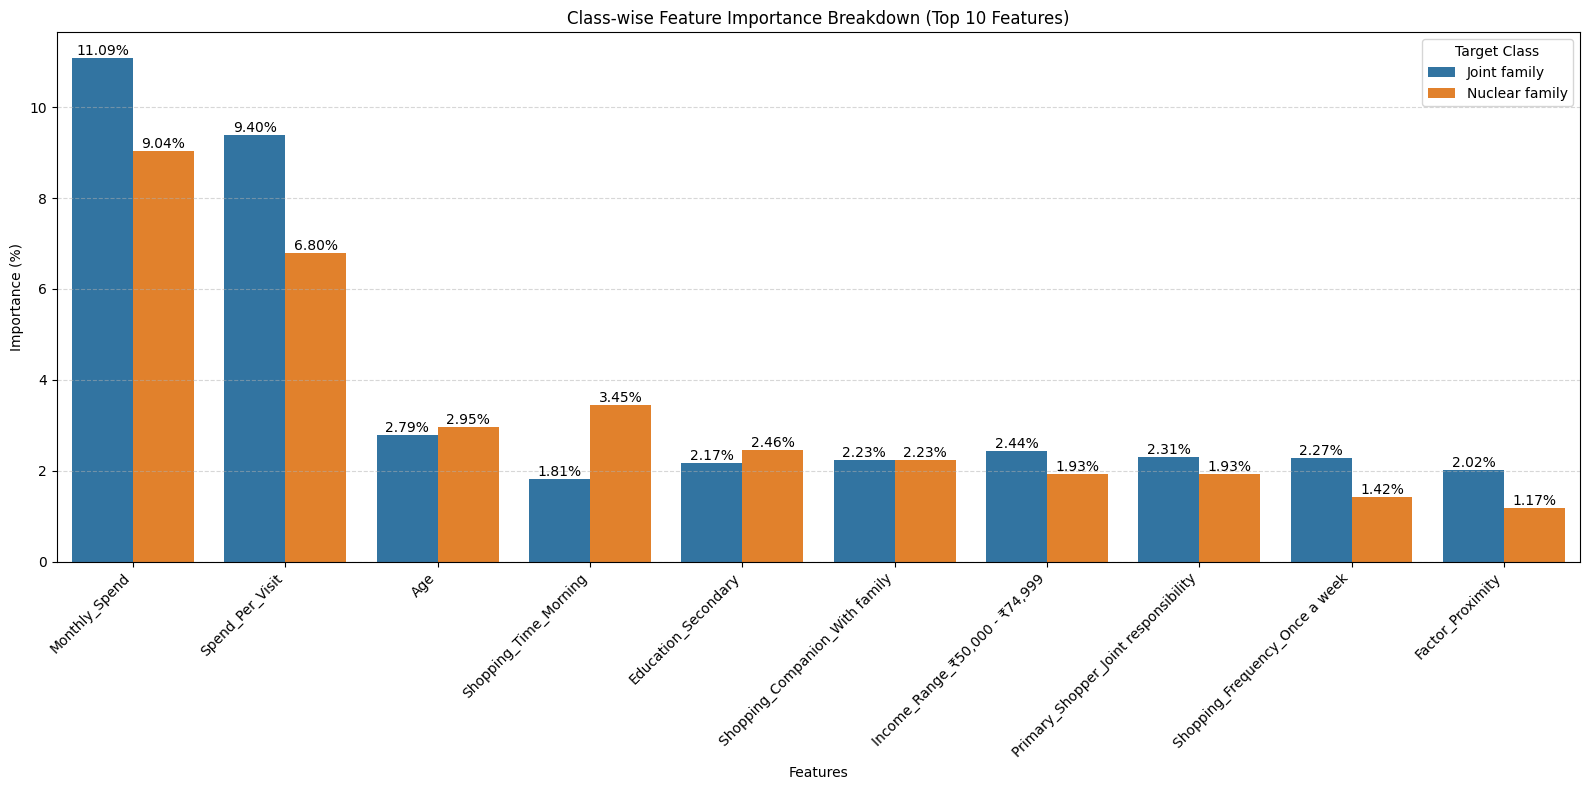

In [7]:
# ---------------------------------------
# 9. Class-wise Feature Importance Breakdown
# ---------------------------------------

# Map class labels
class_names = decision_tree.classes_

def get_class_wise_feature_importance(tree, feature_names, class_names):
    tree_ = tree.tree_
    n_classes = len(class_names)

    # Initialize dictionaries
    feature_contrib = {cls: {f: 0.0 for f in feature_names} for cls in class_names}
    total_contrib = {f: 0.0 for f in feature_names}

    def recurse(node):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            feature = feature_names[tree_.feature[node]]
            left, right = tree_.children_left[node], tree_.children_right[node]

            # Impurity decrease at this node
            impurity_decrease = tree_.impurity[node] - (
                tree_.impurity[left] * tree_.n_node_samples[left] +
                tree_.impurity[right] * tree_.n_node_samples[right]
            ) / tree_.n_node_samples[node]

            if impurity_decrease < 0:
                impurity_decrease = 0  # Just in case of rounding errors

            class_counts = tree_.value[node][0]
            class_distribution = class_counts / class_counts.sum()

            for idx, cls in enumerate(class_names):
                feature_contrib[cls][feature] += impurity_decrease * class_distribution[idx]

            total_contrib[feature] += impurity_decrease

            recurse(left)
            recurse(right)

    recurse(0)

    # Normalize class-wise contributions per feature to sum up to the total importance from sklearn
    sklearn_importances = dict(zip(feature_names, tree.feature_importances_))

    rows = []
    for feature in feature_names:
        total = total_contrib[feature]
        if total == 0:
            continue
        for cls in class_names:
            raw_cls_contrib = feature_contrib[cls][feature]
            normalized_cls_contrib = (raw_cls_contrib / total) * sklearn_importances[feature] * 100
            rows.append({
                "Feature": feature,
                "Target Class": cls,
                "Importance": normalized_cls_contrib
            })
    return pd.DataFrame(rows)

# Apply function
importance_df = get_class_wise_feature_importance(decision_tree, feature_names, class_names)

# Compute total importance for sorting and keep top 10
top_features = (
    importance_df.groupby("Feature")["Importance"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

importance_df = importance_df[importance_df["Feature"].isin(top_features)]
importance_df["Feature"] = pd.Categorical(importance_df["Feature"], categories=top_features, ordered=True)

# ---------------------------------------
# 10. Visualization
# ---------------------------------------
plt.figure(figsize=(16, 8))
ax = sns.barplot(data=importance_df, x="Feature", y="Importance", hue="Target Class")

# Fix: Skip annotations for values <= 0.01 to avoid showing misleading 0.00%
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height) and height > 0.01:  # Ensures tiny values aren’t annotated
        ax.annotate(f"{height:.2f}%", 
                    (p.get_x() + p.get_width() / 2., height),
                    ha="center", va="bottom", fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.xlabel("Features")
plt.ylabel("Importance (%)")
plt.title("Class-wise Feature Importance Breakdown (Top 10 Features)")
plt.legend(title="Target Class")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### **Class-wise Feature Importance Breakdown**

#### **Overview**
This bar chart provides a **detailed comparison** of feature importance in classification, showing how specific attributes influence **Joint family** and **Nuclear family** grocery shopping behaviors. Each feature is analyzed separately for both family structures.

#### **Key Insights**
✅ **Monthly Spend & Spend Per Visit Dominate** → These two features collectively contribute **~37%** importance, reinforcing that **spending habits are the most defining factors** in determining family structure.  
✅ **Age Matters, but Slightly Differently** → **Age importance is similar for both classes (~2.8-2.9%)**, indicating that while age influences grocery decisions, it does not drastically differ between family structures.  
✅ **Shopping Time Preferences Vary** → **Morning shopping is more important for Nuclear families (3.45%) than for Joint families (1.81%)**, suggesting **time-based shopping habits distinguish Nuclear families more clearly**.  
✅ **Education Level & Income Are Crucial but Balanced** → **Joint and Nuclear families show similar importance (~2-2.5%)** for **Education (Secondary) and Income range ₹50,000–₹74,999**, implying that economic and educational factors play **a consistent role across both classifications**.  
✅ **Shopping Companion - With Family Is Equally Important (2.23%)** → **Both Joint and Nuclear families value shopping with family**, meaning **it’s not a distinguishing factor but confirms the influence of collective grocery decision-making**.  
✅ **Primary Shopper Responsibility Differs Slightly** → **Nuclear families show higher importance for “Joint Responsibility” (2.27%)** than Joint families (1.93%), suggesting **more shared decision-making in Nuclear families’ grocery habits**.  
✅ **Shopping Frequency Impact Varies** → **Once-a-week shopping is more important for Joint families (2.27%)** than Nuclear families (1.42%), possibly indicating **Joint families prefer bulk purchasing over frequent smaller trips**.  
✅ **Proximity Plays a Role, More in Joint Families** → **Joint families prioritize proximity (2.02%) over Nuclear families (1.17%)**, suggesting **location convenience may influence bulk-shopping preferences in Joint families**.

#### **Implications for Grocery Shopping Decision Analysis**
📌 **Spending habits remain the strongest predictive factor** for classifying family structures.  
📌 **Time-based shopping preferences, shopping responsibility, and proximity factor contribute uniquely** to the classification process, offering potential targeted marketing insights.  
📌 **Behavioral patterns like shopping frequency and companion choice reveal underlying decision-making strategies in grocery shopping for both Joint and Nuclear families**.  

5️⃣ **Decision Path Analysis for Joint vs Nuclear Families** 

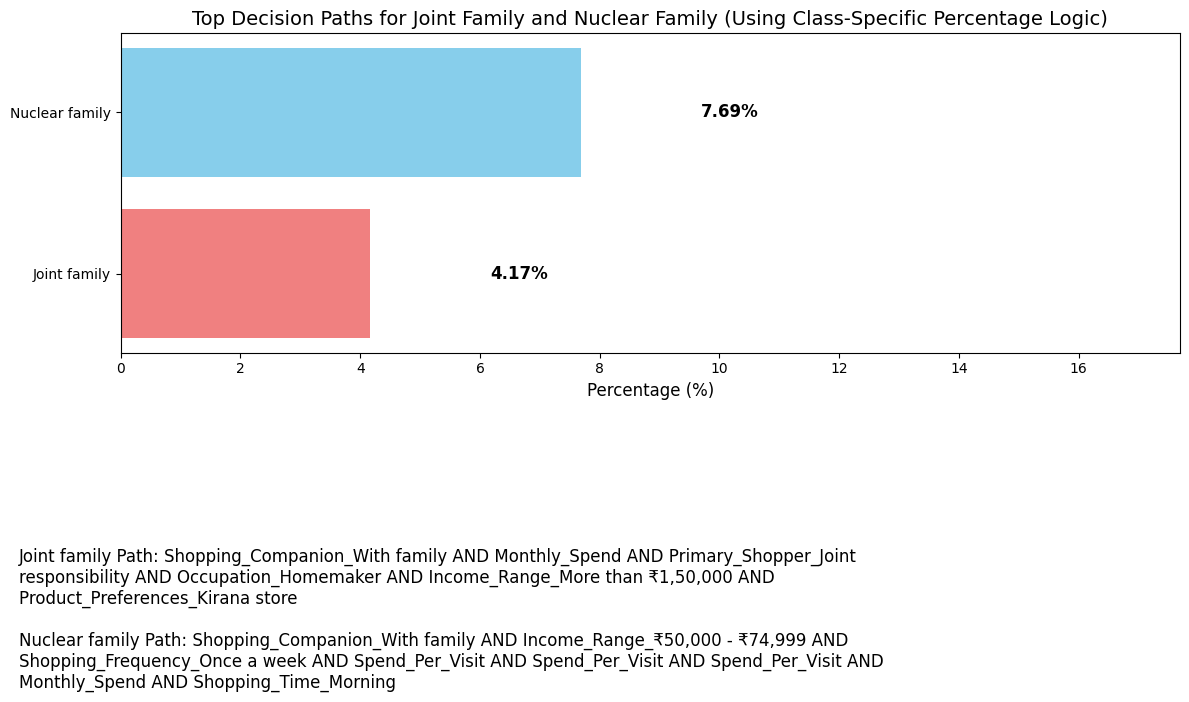

In [11]:
# To identify and visualize the most frequently occurring decision paths in a 
# Decision Tree model for classifying individuals into Joint Family or Nuclear Family 
# based on their shopping behaviors and demographic attributes

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
from sklearn.tree import _tree

# Function to extract the top decision path for each target class using percentage logic
def extract_top_decision_path_percentage(tree, feature_names, class_names):
    tree_ = tree.tree_
    paths = {cls: {} for cls in class_names}

    def recurse(node, path):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:  # Not a leaf node
            feature = feature_names[tree_.feature[node]]

            left_path = path + [feature]
            right_path = path + [feature]

            recurse(tree_.children_left[node], left_path)
            recurse(tree_.children_right[node], right_path)
        else:
            class_counts = tree_.value[node][0]
            predicted_class = class_names[np.argmax(class_counts)]
            rule = " AND ".join(path)

            if rule not in paths[predicted_class]:
                paths[predicted_class][rule] = 1
            else:
                paths[predicted_class][rule] += 1

    recurse(0, [])  # Start recursion

    # Convert data into DataFrame format
    df_list = []
    for cls, rule_counts in paths.items():
        total_paths = sum(rule_counts.values())  # Total paths for that class
        top_rule = max(rule_counts, key=rule_counts.get)  # Most frequent path
        percentage = (rule_counts[top_rule] / total_paths) * 100  # Class-wise percentage

        df_list.append({"class": cls, "rule": top_rule, "percentage": percentage})

    return pd.DataFrame(df_list)

# Extract top decision paths using percentage-based logic
top_decision_paths_df = extract_top_decision_path_percentage(decision_tree, feature_names, decision_tree.classes_)

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top_decision_paths_df["class"], top_decision_paths_df["percentage"], color=["lightcoral", "skyblue"])

# Annotate bars with percentage values
for i, bar in enumerate(bars):
    ax.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2,
            f"{top_decision_paths_df['percentage'].iloc[i]:.2f}%",
            va='center', ha='left', fontsize=12, weight='bold', color="black")

# Adjust labels and limits
ax.set_xlim(0, max(top_decision_paths_df["percentage"]) + 10)
ax.set_xlabel("Percentage (%)", fontsize=12)
ax.set_title("Top Decision Paths for Joint Family and Nuclear Family (Using Class-Specific Percentage Logic)", fontsize=14)

# Show decision paths below the chart without numbers or operators
wrapped_rules = [textwrap.fill(f"{top_decision_paths_df['class'].iloc[i]} Path: {top_decision_paths_df['rule'].iloc[i]}", width=100) for i in range(len(top_decision_paths_df))]
plt.figtext(0.02, -0.15, "\n\n".join(wrapped_rules), wrap=True, horizontalalignment='left', fontsize=12)

plt.tight_layout(rect=[0, 0.3, 1, 1])
plt.show()

### **Decision Path Comparison for Joint Family vs Nuclear Family**

#### **Overview**
This bar chart illustrates the **top decision paths** that most significantly influence classification for **Joint family vs Nuclear family**, using **class-specific percentage logic** to show **dominance within each family type**.

#### **Key Insights**
✅ **Nuclear family path appears more frequently (7.69%)** than the **Joint family path (4.17%)**, indicating that Nuclear families **follow more predictable shopping behaviors**, making classification easier.  
✅ **Joint family Path Influencing Factors:**  
   - **Shopping with family** → Reinforces collective grocery decision-making in Joint families.  
   - **High monthly spending** → Supports the trend that Joint families **purchase in bulk** for household consumption.  
   - **Joint responsibility in shopping** → Confirms **shared decision-making roles** in grocery purchases.  
   - **Homemakers drive purchases** → Suggests that **homemakers in Joint families** play a leading role in shopping choices.  
   - **High-income segment (₹1,50,000+)** → Indicates a **higher financial capacity for grocery spending in Joint households**.  
   - **Preference for Kirana stores** → Shows **local store preference for Joint families**, possibly due to traditional shopping habits.

✅ **Nuclear family Path Influencing Factors:**  
   - **Shopping with family** → Even in Nuclear families, shopping is often **a collective activity**.  
   - **Mid-range income (₹50,000–₹74,999)** → Suggests **budget-conscious grocery spending behaviors**.  
   - **Weekly shopping frequency** → Indicates **consistent grocery purchases**, rather than bulk buying.  
   - **Spend per visit dominance** → Suggests **Nuclear families emphasize spending amounts per trip rather than overall monthly budgets**.  
   - **Morning shopping habits** → Possibly reflects **work-life schedules, optimizing grocery shopping timings**.

#### **Implications for Grocery Shopping Decision Analysis**
📌 **Joint families exhibit traditional bulk shopping behaviors**, prioritizing **high spending, shared decision-making, and Kirana store purchases**.  
📌 **Nuclear families show structured, predictable shopping habits**, emphasizing **weekly frequency, moderate income-based budgeting, and individual spending decisions per visit**.  
📌 **Retailers can target these insights:**  
   - **For Joint families:** Focus on **family pack deals, bulk discounts, and traditional/local store promotions**.  
   - **For Nuclear families:** Optimize **weekly shopping promotions, personalized spending-based discounts, and time-sensitive offers for morning shoppers**.

#### **(Lower Percentage Values)**
- It calculates the **percentage based on all paths leading to a specific class**.
- If there are **100 total paths for Joint Family** and one path appears **30 times**, the percentage is **(30 / 100) × 100 = 30%**.
- **Why it's useful:** It shows the **dominance of a decision path within its own class**, helping understand **which rules drive classification** more precisely.

6️⃣ **Age Group Distribution in Decision Paths**  

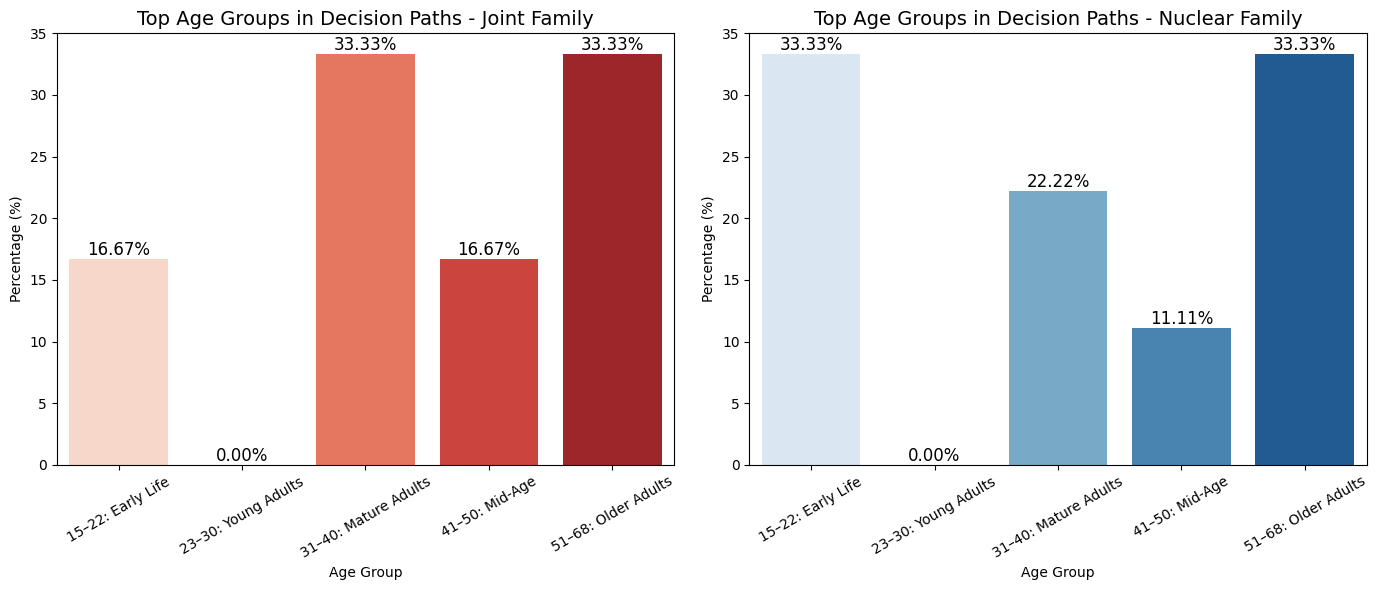

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import _tree
from sklearn.preprocessing import RobustScaler

# Define custom age bins and labels
bins = [0, 22, 30, 40, 50, 68]
labels = [
    '15–22: Early Life', 
    '23–30: Young Adults', 
    '31–40: Mature Adults', 
    '41–50: Mid-Age', 
    '51–68: Older Adults'
]

# Initialize RobustScaler (assuming it was used in preprocessing)
scaler = RobustScaler()
scaler.fit(df[['Age']])  # Fit the scaler using the original Age values

# Function to extract and inverse transform age values from decision paths
def extract_age_decision_paths(tree, feature_names, class_names, scaler):
    tree_ = tree.tree_
    paths = {cls: [] for cls in class_names}

    def recurse(node, path):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            feature = feature_names[tree_.feature[node]]
            threshold = tree_.threshold[node]

            # If the feature is Age, store its value after inverse transformation
            if "Age" in feature:
                original_age = scaler.inverse_transform(np.array([[threshold]]))[0][0]  # Convert back to original age scale
                path.append(original_age)

            recurse(tree_.children_left[node], path.copy())  # Left branch
            recurse(tree_.children_right[node], path.copy())  # Right branch
        else:
            class_counts = tree_.value[node][0]
            predicted_class = class_names[np.argmax(class_counts)]
            if path:
                paths[predicted_class].extend(path)  # Store transformed Age values for classification

    recurse(0, [])  # Start recursion

    return paths

# Extract age decision paths
age_paths = extract_age_decision_paths(decision_tree, feature_names, decision_tree.classes_, scaler)

# Convert extracted ages into bins
def bin_age_values(age_list, bins, labels):
    age_series = pd.Series(age_list)
    return age_series.groupby(pd.cut(age_series, bins=bins, labels=labels)).count()

# Count age occurrences for each family structure
joint_family_age_distribution = bin_age_values(age_paths["Joint family"], bins, labels)
nuclear_family_age_distribution = bin_age_values(age_paths["Nuclear family"], bins, labels)

# Convert counts to percentage
joint_family_age_distribution = (joint_family_age_distribution / joint_family_age_distribution.sum()) * 100
nuclear_family_age_distribution = (nuclear_family_age_distribution / nuclear_family_age_distribution.sum()) * 100

# Create a DataFrame for visualization
age_df = pd.DataFrame({
    "Age Group": labels,
    "Joint Family": joint_family_age_distribution.values,
    "Nuclear Family": nuclear_family_age_distribution.values
})

# Creating separate bar charts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Joint Family Age Distribution
sns.barplot(data=age_df, x='Age Group', y='Joint Family', ax=axes[0], palette='Reds')

# Annotate each bar with percentage value
for p in axes[0].patches:
    height = p.get_height()
    axes[0].annotate(f"{height:.2f}%", (p.get_x() + p.get_width() / 2., height),
                     ha="center", va="bottom", fontsize=12)

axes[0].set_title('Top Age Groups in Decision Paths - Joint Family', fontsize=14)
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Percentage (%)')

# Nuclear Family Age Distribution
sns.barplot(data=age_df, x='Age Group', y='Nuclear Family', ax=axes[1], palette='Blues')

# Annotate each bar with percentage value
for p in axes[1].patches:
    height = p.get_height()
    axes[1].annotate(f"{height:.2f}%", (p.get_x() + p.get_width() / 2., height),
                     ha="center", va="bottom", fontsize=12)

axes[1].set_title('Top Age Groups in Decision Paths - Nuclear Family', fontsize=14)
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Percentage (%)')

# Rotate labels for better readability
axes[0].tick_params(axis='x', rotation=30)
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

### **Top Age Groups in Decision Paths for Joint vs Nuclear Families**

#### **Overview**
This pair of bar charts highlights the **most influential age groups** in determining whether an individual belongs to a **Joint family or Nuclear family**, based on classification decision paths.

#### **Key Insights**
✅ **Dominant Age Groups in Joint Families**  
   - **31–40 (Mature Adults) & 51–68 (Older Adults) each contribute 33.33%**  
   - **15–22 (Early Life) & 41–50 (Mid-Age) account for 16.67% each**  
   - 📌 **Implication:** **Middle-aged and older individuals are more frequently associated with Joint family classifications**, suggesting **traditional household structures with shared financial and grocery responsibilities**.

✅ **Dominant Age Groups in Nuclear Families**  
   - **15–22 (Early Life) contributes the highest share at 33.33%**  
   - **51–68 (Older Adults) also contributes 33.33%**  
   - **31–40 (Mature Adults) is lower at 22.22%, and 41–50 (Mid-Age) even lower at 11.11%**  
   - 📌 **Implication:** **Young individuals appear more frequently in Nuclear family classifications**, reinforcing **the trend that Nuclear families may be independent and self-sufficient in grocery decisions**.

✅ **Absence of 23–30 (Young Adults) in Both Family Types**  
   - **No paths exist for this age group**, meaning individuals **aged 23–30 did not significantly contribute to classification decisions**.  
   - 📌 **Potential reasons:**  
     1. **Few people in this age range in the dataset** → Might indicate a data distribution gap.  
     2. **Age 23–30 does not heavily impact shopping behavior** → Suggests shopping habits of Young Adults may not strongly differ between Joint and Nuclear families.

#### **Implications for Grocery Shopping Decision Analysis**
📌 **Older adults play a major role in shopping decisions for both family structures**, particularly in **Joint families** where shared household consumption is common.  
📌 **Young adults (15–22) drive grocery behaviors in Nuclear families**, possibly due to **self-sufficient shopping habits or independent living scenarios**.  
📌 **Retailers should adjust marketing strategies**:  
   - **For Joint families:** Focus on **bulk purchases, traditional family-oriented grocery products, and shared decision-making incentives**.  
   - **For Nuclear families:** Offer **individual convenience shopping options, digital promotions, and young-adult-friendly grocery items**.

# Overall

**"Understanding how shopping habits, personal choices, and demographics influence grocery decisions in Joint and Nuclear families."**  

1️⃣ **Classification Performance Analysis** → Start with the model’s **overall accuracy (87%)**, explaining how well it distinguishes **Joint vs Nuclear families** using precision, recall, and F1-score.

2️⃣ **Monthly Spend, Spend Per Visit & Age Comparison** → Introduce key **spending behavior trends** showing that **Joint families spend more per month and per visit**, while **Nuclear families shop more frequently but spend less per trip**. Age differences establish demographic influences on shopping.

3️⃣ **Top Feature Importance Analysis** → Highlight the most **influential features driving classification**, emphasizing **spending habits, age, shopping time, education, and family shopping behaviors**.

4️⃣ **Class-wise Feature Importance Breakdown** → Compare **Joint family vs Nuclear family feature influence separately**, showing **how behavioral nuances (e.g., morning shopping, weekly frequency) shape classification**.

5️⃣ **Decision Path Analysis for Joint vs Nuclear Families** → Show the **top paths that drive classification**, explaining how **spending behaviors, shopping responsibility, and income levels affect family-based grocery decisions**.

6️⃣ **Age Group Distribution in Decision Paths** → Finish with **age-based classification**, showing that **older adults drive Joint family decisions**, while **younger individuals influence Nuclear family trends**.